#### Automatic Summary Evaluation

This project demonstrates an LLM-as-a-judge technique to evaluate summaries generated by machine learning models. Summary evaluation is a useful application of LLMs in production environments and has analogies in similar evaluations of GenAI outputs (or the automated evaluation of human outputs).

This notebook uses data from SummEval [1] which is a dataset of CNN and Daily Mail articles, machine generated summaries of those articles, and human evaluations of those summaries. In this notebook, a G-Eval technique is used to evaluate the summaries on consistency. G-Eval achieves relatively high correlation with human evaluations with the benefit that it can be used with a foundational model and does not require fine-tuning to achieve that relatively high correlation.

G-Eval [2] was originally used to better measure Relevance, Consistency, Fluency, and Coherence. Relevance being the measure of how well the summary captures the key points of the article. Consistency being the measure of whether the summary reproduces all facts accurately and does not make up untrue information. Fluency being the measure of the quality of individual sentences (grammatically correct). Coherence being the measure of the quality of the summary as a whole.

In general, machine written summaries are highly Fluent and Coherent [3] - to the point that focus as can shift entirely to Relevance and Consistency. Relevance is not as "solved" as Fluency or Coherence, but LLMs often produce output with acceptable levels of relevance. The biggest struggle for LLMs is often consistency - coming from an incorrect representation of events in the source text. These incorrect representations are known as hallucinations and can be an incorrect description of events that contradict the source (known as intrinsic hallucinations), or the introduction of new information that cannot be verified by the source (extrinsic hallucinations). that being said, SummEval was published in 2020 and the summaries of the dataset were produced with non-LLM models and are therefore not always fully fluent or coherent.

This implementation of G-Eval uses several custom prompts as well as a modified version of an example prompt from Microsoft's Prompt Flow [4].

In [1]:
import os
import json
from typing import Union, Tuple, Dict, Callable

from numpy.typing import ArrayLike
import asyncio
import aiohttp
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau

import llm_utils
from llm_utils import LlmUtils

# Dataset paths
SUMM_EVAL_DATA = "./data/summEval/summeval.json"

# Cached request/responses
CACHE_PATH = "./data/summEval/llm_cache.pkl"

# Async Parameters
NUM_PARALLEL_CONNS_LLAMA = 3
NUM_PARALLEL_CONNS_GPT = 2

#### The Dataset

This dataset is from SummEval and is comprised of full text (source) articles from CNN and Daily Mail, summaries generated by various NLP models, and human evaluations of those summaries.

For this notebook, the only score we are interested in is the consistency score. Consistency can have multiple definitions in the literature and in practice, but the definition given to the human evaluators for SummEval was: "The [Consistency] rating measures whether the facts in the summary are consistent with the facts in the original article. Consider whether the summary does reproduce all facts accurately and does not make up untrue information."

It has been several years since SummEval has been published. Since then, much of the literature has broken consistency into 2 metrics: faithfulness (also known as groundedness) and coverage (also known as completeness or recall). This notebook will focus on a generic consistency since there is not ground truth data for faithfulness or coverage in the SummEval dataset.

There is an interesting, almost philosophical, discussion to be had about faithfulness and coverage. Domain specific language, especially with easy to understand definitions, can often be useful when discussing with stakeholders because it can avoid miscommunication. Faithfulness is defined as staying consistent and truthful to the provided source, and we do not consider ‘factuality’ where valid external facts are acceptable [3]. A summary that omits details but isn't otherwise misleading or inaccurate would still be faithful. Not considering factuality means a factually inaccurate piece of information in the source should be faithfully represented in the summary. Therefore, a faithful summary of a flat-earther article would have the same factual inaccuracies that are present in the source article. Coverage is defined as the comprehensiveness of the summary and quantifies how well a summary captures and accurately represents key information from the source. A summary that contains all information from the text, but hallucinates new information, so long as the hallucinations do not mislead or inaccurately represent the source, would still have high coverage.

If a stakeholder says a summary is unacceptable due to low factual accuracy, that may mean a number of things - the model is making up information (low faithfulness - external hallucinations), the model is confusing information like who-did-what (low faithfulness - intrinsic information), the model is missing information (low coverage), etc. It is important to discuss and find patterns in the output, and having appropriate language goes a long way to fill in communication gaps.

In [2]:
# Data used for evaluation available from the G-Eval paper's GitHub repo
#   https://raw.githubusercontent.com/nlpyang/geval/refs/heads/main/data/summeval.json
summ_eval = json.load(open(SUMM_EVAL_DATA))
summ_eval = pd.DataFrame(summ_eval)
summ_eval["consistency"] = summ_eval["scores"].apply(lambda x: x["consistency"])
summ_eval.drop(["doc_id", "system_id", "reference", "scores"] , axis=1, inplace=True)
summ_eval.rename(columns={"source": "article", "system_output": "summary"}, inplace=True)

# At the time of publication, 5 articles (and all 16 summaries associated with each of the articles) get flagged by the
#   Azure OpenAI Service's Content Filter, even on the most permissive settings
# This filter can be removed for trusted users so long as they still uphold Microsoft's content moderation policies
#   My personal account is not a trusted user, so I cannot remove the content filter
# I enumerate each index explicitly because it would be possible for a specific summary to be flagged, but the other
#   summaries associated with the same article. This makes it easier to apply to a new dataset in the future
# Even though I could process these with the Ollama models, I am just going to ignore them for simplicity
azure_error_indices = [
      80,   81,   82,   83,   84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
     352,  353,  354,  355,  356,  357,  358,  359,  360,  361,  362,  363,  364,  365,  366,  367,
     448,  449,  450,  451,  452,  453,  454,  455,  456,  457,  458,  459,  460,  461,  462,  463,
    1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487,
    1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535
]
summ_eval.drop(azure_error_indices, inplace=True)

#### Calling the models

This notebook compares the performance of 4 models on 4 prompts.

The models are Llama3.2-vision [5], Phi4 [6], DeepSeek-R1-Distill-Qwen-14B [7], and GPT-4o mini [8]. 
* Llama3.2-vision is an 11B parameter model released by Meta in 09/2024
* Phi4 is a 14B parameter model released by Microsoft in 12/2024
* DeepSeek-R1-Distill-Qwen-14B uses the Qwen-14B model architecture and was distilled from DeepSeek-R1 (released by DeepSeek in 01/2025)
* GPT 4o mini is OpenAI's "most cost-efficient small model" and was released in 07/2024

All models except GPT-4o mini are open source and are called using a local OLLAMA server. GPT-4o mini is called using the Azure OpenAI Service. It would be easy to compare more models, especially ones available on Ollama or Azure OpenAI Service. The open-source models were selected because they are the most performative (and largest) models that I can reasonably run on my personal GPU. GPT-4o mini was selected because it is the most performative model for which I am willing to pay the monetary cost. GPT-4o and o1-mini are both more than an order of magnitude more expensive and o1 is nearly 2 orders of magnitude more expensive.

Both OLLAMA and the Azure OpenAI Service use similar REST API endpoints, but there are some small differences between the APIs. All differences are contained and managed by llm_utils.

In [3]:
# All the calls to the LLMs get saved to a 'cache', just a dictionary with requests as keys and responses as values
# This is useful when rerunning and adding new models or otherwise experimenting or debugging since the calls to the
#   LLMs are expensive both in time and for GPT, money. 

# I'm using a try-except in this manner so I can re-run the full notebook without accidentally overwriting the cache.
# The cache is pickled and saved to disk once all samples are passed through a prompt-model pair
try:
    CACHE
except:
    if os.path.exists(CACHE_PATH):
        with open(CACHE_PATH, "rb") as f:
            CACHE = pickle.load(f)
    else:
        CACHE = dict()

In [4]:
# Creates the request payload for the model calls
# Uses structured outputs to ensure the model gives a output than can be parsed
def get_request_payload(
        model_name: llm_utils.AllowedModelNames,
        prompt: Union[str, Tuple[str, str]]
) -> dict:
    """ Creates the request payload for the given model
    """
    # Set some fields based on the inputs
    model_type = LlmUtils.get_model_type(model_name)
    num_output_tokens = 10
    seed = 314159265

    # If randomness options were not supplied, set them to minimum values
    temperature = 0.0
    top_p = 0.0
    top_k = 1

    # Create the portions of the request payload that are identical between Ollama and Azure OpenAI
    payload = {
        "stream": False,
    }

    # Create the Ollama specific portions if this is a llama request
    if model_type == "ollama":
        payload["prompt"] = prompt
        payload["model"] = model_name
        payload["options"]= {
            "seed": seed,
            "temperature": temperature,
            "top_p": top_p,
            "top_k": top_k,
            "num_predict": num_output_tokens
        }

        payload["format"] = {
            'properties': {
                'score': {
                    'enum': [1, 2, 3, 4, 5],
                    'title': 'Score',
                    'type': 'integer'
                }
            },
            'required': ['score'],
            'title': 'score',
            'type': 'object'
        }

    # Create the Azure OpenAI specific portions if this is a GPT request
    else:
        payload["messages"] = (
            {
                "role": "system",
                "content": prompt[0]
            },
            {
                "role": "user",
                "content": prompt[1]
            }
        )
        payload["seed"] = seed
        payload["temperature"] = temperature
        payload["top_p"] = top_p
        payload["max_tokens"] = num_output_tokens

        payload["response_format"] = {
            "type": "json_schema",
            "json_schema": {
                "name": "score",
                "schema": {
                    "type": "object",
                    "properties": {
                        "score": {
                            "enum": [1, 2, 3, 4, 5],
                            "type": "integer"
                        }
                    },
                    "required": ["score"],
                    "additionalProperties": False
                },
                "strict": True
            }
        }

    return payload

#### Scoring Metric

Once all summaries are scored, the correlation between those scores and the human evaluations is measured. Correlation is measured using Pearson, Spearman, and Kendall-Tau correlation. Pearson correlation measure the linear relationship between the machine scores and human evaluations while Spearman and Kendall-Tau look more so at the ranking of the data and compare the monotonic relationship between the machine scores and human evaluations. All 3 metrics will likely be directionally correct, but Kendall-Tau is typically more robust when dealing with tied ranks and would be the preferred metric if we were trying to find the best model/prompt.

On the subject of tied rankings: G-Eval outputs a binned score - an integer with values 1, 2, 3, 4, 5. In practice, this leads to ~500-way ties in the ranking of article-summary pairs. Allowing for so many ties makes the evaluation task significantly easier. The authors of G-Eval noted this fact, and they also confessed it likely explains why the normalized probability score (which was a continuous score from 1-5) was worse than the binned integer score.

In [5]:
# Calculate the correlation between the model and human evaluations
def summEval_correlations(y_true: ArrayLike, y_pred: ArrayLike)-> Tuple[float, float, float]:
    pearson = pearsonr(y_true, y_pred)[0]
    spearman = spearmanr(y_true, y_pred)[0]
    kendall_tau = kendalltau(y_true, y_pred)[0]
    return pearson, spearman, kendall_tau

#### G-Eval Prompting

A G-Eval-based defines a metric in the prompt then instructs a non-fine-tuned large language model to return the score using that metric given an example. In our case, the metric is consistency and the example is a summary-article pair. In my implementation, the model is instructed to (and forced by the structured outputs API) to return a JSON of the score. Enforcing a JSON output ensures that the score will be able to be parsed.

The prompts do not include any advanced prompt engineering techniques such as Chain of Thought, Few-Shot Prompting, etc. Different models respond differently to advanced prompt engineering techniques, and aren't included as this is a simple demonstration. 

The prompts are:
* Prompt A is the base prompt. It is the most simple prompt.
* Prompt B is prompt A with an additional, redundant line that repeats part of the instructions.
* Prompt C is prompt B with several additional instructions. It instructs the model to be strict in its output. Notably, the model is well constrained as I use the structured outputs parameters with both Ollama and Azure OpenAI. So instructing it not to output only the score and no newline characters doesn't seem productive. (But apparently is productive because it was the best prompt for all models)
* Prompt D is the Microsoft Prompt Flow example. It is still similar to A, B, and C but is the most dissimilar of the 4. It includes many short sentences, a short list of instructions, and generous newline characters.

The conversation that I will be simulating with stakeholders in regard to G-Eval revolves around inconsistency. In this case, "inconsistency" refers to the LLM generating a different result with a seemingly inconsequential change to the prompt or article-summary pair. To highlight this, I include 3 extremely similar prompts and an additional similar prompt that is from Microsoft Prompt Flow [4]. Ideally, for a given model the 4 prompts should produce similar results. In practice the 4 prompts produce different correlation scores with +/- 5% variation. We might have concerns deploying such a model to production because a small shift in distribution of the incoming text might cause a 5% decline in the model's performance. Without fine-tuning the model, it can be difficult to develop confidence that the model's output will produce good results on new data.

In fairness to LLMs, larger models tend to give more consistent outputs. GPT-4o and o1 tend to be much more consistent, but still not nearly as consistent as other non-LLM models and techniques. I elaborate more in the "Discussion" section.

In [6]:
g_eval_base_system_prompt = """You are a super intelligent artificial intelligence that scores a summary based on its consistency with the source article. Your score is a rating from 1 to 5 (1, 2, 3, 4, 5) with 1 being a bad score and 5 being a good score. Your output is in the following format: {"score": rating} where rating is 1, 2, 3, 4 or 5.
Consistency is defined as the factual alignment between the summary and the source article. A factually consistent summary contains only statements that are entailed by the source article. Summaries that contain inconsistent information should be penalized.
{additional_instructions}
"""

g_eval_base_user_message = """Source Article:
{article}

Summary:
{summary}"""

g_eval_consistency_suffix = """

Consistency JSON:
"""

def g_eval_faithfulness_prompt_a(
        summary: str,
        article: str,
        model_type: llm_utils.ServerTypes
) -> Union[str, Tuple[str, str]]:
    system_prompt = g_eval_base_system_prompt
    system_prompt = system_prompt.replace("{additional_instructions}", "")
    
    user_message = g_eval_base_user_message
    user_message = user_message.replace("{article}", article)
    user_message = user_message.replace("{summary}", summary)
    
    if model_type == "ollama":
        system_prompt = system_prompt + user_message + g_eval_consistency_suffix
        return system_prompt

    else:
        return system_prompt, user_message



def g_eval_faithfulness_prompt_b(
        summary: str,
        article: str,
        model_type: llm_utils.ServerTypes
) -> Union[str, Tuple[str, str]]:
    additional_instructions = "You will be given a summary and the source article. Your task is to answer with the rated score for that summary.\n"
    system_prompt = g_eval_base_system_prompt
    system_prompt = system_prompt.replace("{additional_instructions}", additional_instructions)
    
    user_message = g_eval_base_user_message
    user_message = user_message.replace("{article}", article)
    user_message = user_message.replace("{summary}", summary)
    
    if model_type == "ollama":
        system_prompt = system_prompt + user_message + g_eval_consistency_suffix
        return system_prompt

    else:
        return system_prompt, user_message


def g_eval_faithfulness_prompt_c(
        summary: str,
        article: str,
        model_type: llm_utils.ServerTypes
) -> Union[str, Tuple[str, str]]:
    additional_instructions = g_eval_base_system_prompt + """You will be given a summary and the source article. Your task is to answer with the rated score, and only the score, for that summary.
Your answers should *strictly* be a number from 1 to 5. Do *not* output anything except a single number between 1 and 5.
Do *not* output additional information, comments, or context. Do *not* answer with any spaces, whitespace, newline characters or any other formatting.
"""
    system_prompt = g_eval_base_system_prompt
    system_prompt = system_prompt.replace("{additional_instructions}", additional_instructions)
    
    user_message = g_eval_base_user_message
    user_message = user_message.replace("{article}", article)
    user_message = user_message.replace("{summary}", summary)
    
    if model_type == "ollama":
        system_prompt = system_prompt + user_message + g_eval_consistency_suffix
        return system_prompt

    else:
        return system_prompt, user_message

In [7]:
def g_eval_faithfulness_prompt_d(
        summary: str,
        article: str,
        model_type: llm_utils.ServerTypes
) -> Union[str, Tuple[str, str]]:
    system_prompt = """You will be given a source document. You will then be given one summary written for this source document.

Your task is to rate the summary on one metric.

Please make sure you read and understand these instructions carefully. Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:

Consistency (1-5) - the factual alignment between the summary and the summarized source. A factually consistent summary contains only statements that are entailed by the source document. Annotators were also asked to penalize summaries that contained hallucinated facts.

Evaluation Steps:

1. Read the source document carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the source document. Check if the summary contains any factual errors that are not supported by the source document.
3. Assign a score for consistency based on the Evaluation Criteria.
4. Format your response into a JSON of the form {"score": consistency} where consistency is your score from 1 to 5.
"""

    user_message = f"""Source Document:

{article}

Summary:

{summary}"""

    if model_type == "ollama":
        system_prompt = system_prompt + "\n" + user_message + g_eval_consistency_suffix + "\n"
        return system_prompt

    else:
        return system_prompt, user_message


#### Calling the Models

We have ~1500 pairs of summaries and articles to churn through (several of the examples are removed due to triggering the Azure OpenAI Content Filter). I make these calls asynchronously, though that it is overkill for my local Ollama server and my GPT deployment with a low token per minute rate limit. It is overkill because I then have to limit the number of simultaneous connections to Ollama and GPT otherwise they may timeout waiting in the queue. For GPT, I use exponential backoff to throttle the calls when rate limited is reached.

As mentioned briefly in the "G-Eval Prompting" section, a JSON schema is enforced on the model output to ensure the output will be able to be parsed. Without it, the model can "go rogue" and might output more than just the integer answer that we want. The structured outputs API puts more guardrails on the model and makes them more acceptable for production environments.

In [8]:
async def g_eval_faithfulness(
        model_name: llm_utils.AllowedModelNames,
        session: aiohttp.ClientSession,
        summary: str,
        article: str,
        prompt_base: Callable
        ):
    """ Returns the score for one article-summary pair using the given model and prompt_function
    """
    model_type = LlmUtils.get_model_type(model_name)
    prompt = prompt_base(summary, article, model_type)
    response = await LlmUtils.cached_llm_infer(
        model_name,
        session,
        get_request_payload(
            model_name,
            prompt,
        ),
        CACHE,
        returned_stopped_only=False
    )

    try:
        return int(json.loads(response.strip())['score'])
    except:
        return np.nan


async def g_eval_faithfulnesses(
        model_name: llm_utils.AllowedModelNames,
        summ_eval: pd.DataFrame,
        prompts: Dict[str, Callable]
):
    """ Returns the correlation for the given model on all article-summary pairs for each of the 4 prompts
    """
    # Setup the processing for this model
    model_type = LlmUtils.get_model_type(model_name)
    num_conns = NUM_PARALLEL_CONNS_LLAMA if model_type == "ollama" else NUM_PARALLEL_CONNS_GPT
    connector = aiohttp.TCPConnector(limit=num_conns)
    timeout = aiohttp.ClientTimeout(total=None)

    geval_correlations = {}
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        # Run each prompt
        for prompt_name, prompt_base in prompts.items():
            # asynchronously run each article-summary pair through the model
            geval_tasks = [
                g_eval_faithfulness(model_name, session, summary, article, prompt_base)
                for summary, article in zip(summ_eval["summary"], summ_eval["article"])
            ]
            geval_results = await asyncio.gather(*geval_tasks)
            
            geval_correlations[prompt_name] = summEval_correlations(summ_eval["consistency"], geval_results)
            
            with open(CACHE_PATH, "wb") as f:
                pickle.dump(CACHE, f, pickle.HIGHEST_PROTOCOL)

    return geval_correlations


In [9]:
prompts = {
    "A": g_eval_faithfulness_prompt_a,
    "B": g_eval_faithfulness_prompt_b,
    "C": g_eval_faithfulness_prompt_c,
    "D": g_eval_faithfulness_prompt_d
}
g_eval_correlations = {
    "phi4": await g_eval_faithfulnesses("phi4", summ_eval, prompts),
    "llama3.2-vision": await g_eval_faithfulnesses("llama3.2-vision", summ_eval, prompts),
    "deepseek-r1:14b": await g_eval_faithfulnesses("deepseek-r1:14b", summ_eval, prompts),
    "gpt4o-mini": await g_eval_faithfulnesses("gpt4o-mini", summ_eval, prompts),
}

#### Performance

The performance here is actually nearly state-of-the-art. There are several methods that can do better for consistency, but this performance is high given we had no training data.

That being said, all models but Phi4 had a large variation in correlation
* Phi4 was the lowest variation, only changing by +/- 2%. This still isn't great, but likely acceptable
* Llama3.2-vision varied by ~5% for the Spearman and Kendall-Tau scores. Which are our preferred scores due to tied rankings
* DeepSeek-R1-Distill-Qwen-14B was all over then place. It was both the lowest performing model and had the highest variation. +/- 16%, which is unacceptable
* GPT-4o mini had a moderate amount of variation. Still pretty high in my opinion at +/- 3-4%

Other broad patterns were:
* Prompt C was the best performing prompt for most metrics for all models. Usually followed by A, then B then D
    * This is a little surprising because prompt D was published by Microsoft. The other 3 were hastily written and otherwise untested
* The DeepSeek model performed the worst by far. This model is larger than the Phi4 or llama3.2-vision models, so this is also somewhat surprising
* The other 3 models had roughly equal average performance
    * GPT-4o mini had the highest average performance based on the Spearman and Kendall-Tau metrics, 52.2% and 47.2% respectively
    * Llama3.2-vision had the second highest average performance, 50.0% and 46.8% respectively, but had the highest variation of the 3 performant models 
    * Phi4 was not far behind, with 49.9% and 46.2% respectively. Phi4 also had the lowest variation by far, which makes it an appealing choice

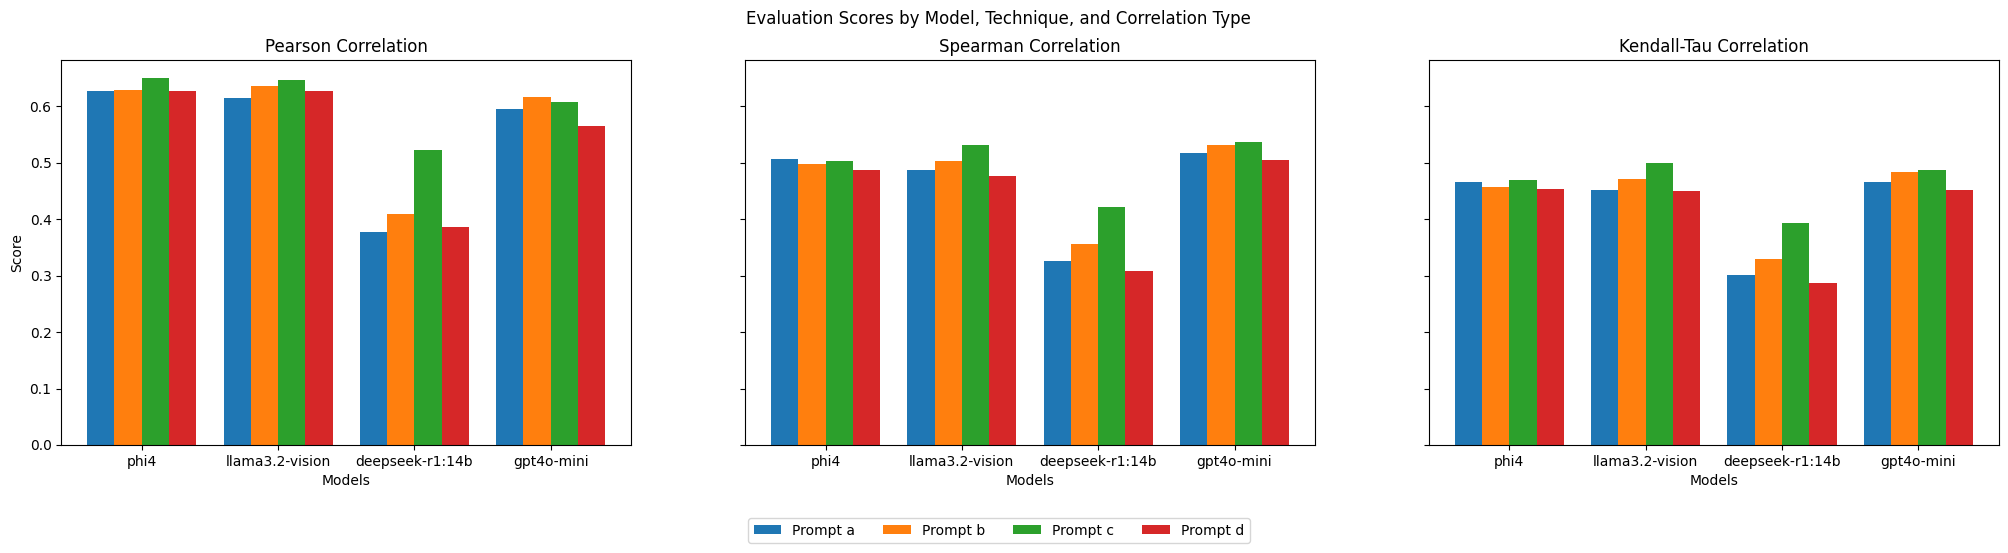

In [10]:
models = list(g_eval_correlations.keys())
prompts = list(g_eval_correlations[models[0]].keys())
correlation_names = ['Pearson', 'Spearman', 'Kendall-Tau']

x = np.arange(len(models))
width = 0.2  # width of bars

fig, axes = plt.subplots(1, len(correlation_names), figsize=(25, 5), sharey=True)
handles = []
labels = [f'Prompt {prompt}' for prompt in prompts]

for i, metric in enumerate(correlation_names):
    ax = axes[i]
    for j, prompt in enumerate(prompts):
        values = [g_eval_correlations[model][prompt][i] for model in models]
        bars = ax.bar(x + j * width, values, width)
        
        # Collect handles and labels only once
        if i == 0:
            handles.append(bars[0])
            ax.set_ylabel("Score")
    
    ax.set_xlabel("Models")
    ax.set_title(f"{metric} Correlation")
    ax.set_xticks(x + width * 1.5)
    ax.set_xticklabels(models)

# Add a single legend to the figure
fig.legend(handles, labels, loc='lower center', ncol=len(prompts), bbox_to_anchor=(0.5, -0.1))
plt.suptitle("Evaluation Scores by Model, Technique, and Correlation Type")
plt.show()

In [11]:
print("Percent Variation")
for model_name, correlations in g_eval_correlations.items():
    correlations = np.array([scores for __, scores in correlations.items()])
    pearsons, spearmans, kendall_taus = correlations[:, 0], correlations[:, 1], correlations[:, 2]
    print(f"\t{model_name}")
    for metric_name, scores in zip(["Pearson", "Spearman", "Kendall-Tau"], [pearsons, spearmans, kendall_taus]):
        percent_range = (max(scores) - min(scores)) / 2 / np.mean(scores) * 100
        print(f"\t\t{metric_name} +/- {np.round(percent_range, 1)}%")
    print()

Percent Variation
	phi4
		Pearson +/- 1.8%
		Spearman +/- 2.0%
		Kendall-Tau +/- 1.6%

	llama3.2-vision
		Pearson +/- 2.4%
		Spearman +/- 5.5%
		Kendall-Tau +/- 5.4%

	deepseek-r1:14b
		Pearson +/- 17.0%
		Spearman +/- 16.0%
		Kendall-Tau +/- 16.1%

	gpt4o-mini
		Pearson +/- 4.3%
		Spearman +/- 3.0%
		Kendall-Tau +/- 3.7%



#### Discussion and Example Application

Hopefully I have shown that LLMs are not a silver bullet and there are concerns in using an LLM for tasks that are not generative in nature. A task such as evaluating the faithfulness of article-summary pairs is likely best to be left to an embedding model rather than a language model.

That being said, LLMs absolutely have their place in the data scientists and machine learning engineer's toolkit - even for evaluation tasks. For one, LLM are often able to very quickly produce a good enough result. Consider the following example, keeping in line with the spirit of the summary-article pairs of SummEval:
* Let's assume we are working on an internal process that summarizes full length transcripts of video calls
* Previously, it was company policy for employees to manually summarize meetings
* The full transcript along with the summary is logged in some records system
* For these summaries, there are company guidelines as far as professional language, factual correctness, etc
* These summaries are important for legal and record keeping reasons
* Many employees find it tedious and time consuming to write these summaries, so we want to improve this process somehow
* It is suggested that all summaries are reviewed to ensure they follow company guidelines before being sent to the record system
* Instead of manually reviewing every summary-transcript pair, we can use a technique like G-Eval to score them based on those existing policies
* Any transcript-summary pair with a score of 3 or lower gets sent back to a human to be revised

Better yet, we can leverage the generative nature of LLMs to create the summaries from the start
* We have the LLM create the summary based on the full transcript
* Feedback from the stakeholders indicates the biggest issue with the summaries is the consistency - they sometimes confuse who-said-what in the transcripts (low faithfulness - intrinsic hallucinations)
* We use a G-Eval-based technique to evaluate the LLM-written transcript-summary pair, sending it back to the LLM to be rewritten if it scores a 3 or lower
* After a summary with a score of 4 or 5 is created, we send it to a human for manual review some % of the time and otherwise send it straight to the record system

The best part about this system was that it could be created quickly. It required no training data and the infrastructure to host the LLM already exists via Azure OpenAI Service or AWS Bedrock. The other parts of this service, like how we show it to the human for review or how we automatically log it in the record system, are necessary regardless of the machine learning technique we use to summarize and evaluate the summaries. Even if this system isn't perfect, we were able to significantly reduce the manual effort needed to write these summaries.

There is a major benefit to quickly creating an imperfect system quickly: "A lot of times, people don't know what they want until you show it to them” - Steve Jobs. Stakeholders (and people in general) often know what improvements can be made, and what would drive business value. However, they don't know how to create that system. In our example, the stakeholders knew they needed to improve the summarization, but didn't know how they could go about doing it. Create a system, even one that is imperfect like G-Eval, closes the gap between a paper diagram and the real world. After creating the system, our stakeholders can re-evaluate if we solved the problem at hand. We have a modular system, so if the summaries aren't good enough due to hallucinations, we can improve the summarization and evaluation portions of the pipeline.

If we wanted to improve the evaluation step of the pipeline, MQAG [9] and TrueTeacher [10] are both techniques that are more correlated with human evaluation of consistency (faithfulness specifically, but they can also be used for coverage). MQAGs has especially high performance on SummEval data.
* MQAG uses a seq2seq model trained on generating multiple choice questions and answers, and an embedding model is trained to answer those questions. The seq2seq model is then used to generate multiple choice questions and answers from the summary. The embedding model is trained to answers those questions based on the source article (without access to the summary). If the embedding model gets the answer incorrect, that implies information in the summary differs from information in the article (and therefore the summary is to some degree unfaithful to the article). Based on the proportion of correct answers, the overall faithfulness of the summary can be calculated.
* TrueTeacher first generates machine written summaries from source articles. Because the summaries are machine written, a percentage are expected to have factual inconsistencies. An LLM, fine-tuned on a similar task, is then used to label each summary-article pair with a binary faithfulness label. An embedding model is then trained on the summary-article pairs with the generated labels as ground truth. The embedding model is eventually able to surpass the performance of the LLM, even though the LLM was used to generate the labels in the first place.

Those methods are great for evaluating consistency, which is the biggest problem with current state-of-the-art machine written summaries. However, there are some drawbacks to those methods:
* They can only be used to evaluate faithfulness or coverage. We would then need a different method to evaluate the professionalism of the summary. And potentially more for other aspects of the summary.
* They require some kind of training data. TrueTeacher can be synthetically generated training data, which is a huge plus, but that still takes a lot of time and resources to develop domain specific training data.

Hopefully, I have shown that G-Eval has its place and how it can be used to kickstart the development process. For some applications, it might be good enough to keep. For others, it is likely be good enough to get started.

#### Citations

[1] Fabbri, Alexander R., et al. "Summeval: Re-evaluating summarization evaluation." Transactions of the Association for Computational Linguistics 9 (2021): 391-409.

[2] Liu, Yang, et al. "G-eval: Nlg evaluation using gpt-4 with better human alignment." arXiv preprint arXiv:2303.16634 (2023).

[3] Maynez, Joshua, et al. "On faithfulness and factuality in abstractive summarization." arXiv preprint arXiv:2005.00661 (2020).

[4] Fujimoto, K., & Maneck, B. (2024, February 24). Prompt flow. Prompt flow - Prompt flow documentation. https://microsoft.github.io/promptflow/ Maneck, B., & Fujimoto, K. (n.d.). Promptflow/examples/flows/evaluation/eval-summarization at main · Microsoft/promptflow. Summarization Evaluation. https://github.com/microsoft/promptflow/tree/main/examples/flows/evaluation/eval-summarization#meta-evaluation 

[5] AI@Meta. (2024). Llama 3.2 Model Card. GitHub. https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/MODEL_CARD.md 

[6] Abdin, Marah, et al. "Phi-4 technical report." arXiv preprint arXiv:2412.08905 (2024).

[7] DeepSeek-AI, et al. ‘DeepSeek-R1: Incentivizing Reasoning Capability in LLMs via Reinforcement Learning’. arXiv [Cs.CL], 2025, http://arxiv.org/abs/2501.12948. arXiv.

[8] GPT-4O Mini: Advancing Cost-Efficient Intelligence. GPT-4o mini: advancing cost-efficient intelligence. (2024, July 18). https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence 

[9] Manakul, Potsawee, Adian Liusie, and Mark JF Gales. "MQAG: Multiple-choice question answering and generation for assessing information consistency in summarization." arXiv preprint arXiv:2301.12307 (2023).

[10] Gekhman, Zorik, et al. "Trueteacher: Learning factual consistency evaluation with large language models." arXiv preprint arXiv:2305.11171 (2023).
